In [1]:
# General imports
%matplotlib inline
import warnings
warnings.filterwarnings('ignore')
import collections
import os
from time import time

# Data Science
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
#import seaborn as sb

# Natural Language processing
import nltk

# Algorithms / estimators
from sklearn.naive_bayes import MultinomialNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.dummy import DummyClassifier

# Metrics
from sklearn.metrics import classification_report
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_curve
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import auc

# Feature Extraction
from sklearn.feature_extraction.text import TfidfVectorizer

# Process
from sklearn.cross_validation import StratifiedShuffleSplit
from sklearn.cross_validation import train_test_split
from sklearn.cross_validation import StratifiedKFold
from scipy import interp

# Corpus
from documentModel import DocumentModel as DM
from export_results import *

from scipy import stats

def is_significant(model_1, model_2, significance = 0.05):
    
    p_value = stats.wilcoxon(recall_avg[model_1], recall_avg[model_2])[1]
    print(p_value)
    if p_value < significance:
        print("It is statically significant")
    else:    
        print("It is NOT statically significant")

def save_image(image, url='../images/', name = 'default'):
    image.savefig(url + name)    

# Business Rule Classification

In [3]:
stop_words = ['a', 'bajo', 'en', 'para','un', 'la', 'el', 'los', 'las', 'su', 'sus', 'través', 'al','con', \
             'más', 'muy', 'cual', 'poco', 'que']

print("Transforming annotated files into training datasets...")
dm = DM()
fito_dataset = dm.get_sentences(0)
X, y = fito_dataset["data"], fito_dataset["target"]

print("OK")

Transforming annotated files into training datasets...
OK


In [30]:
rule_data = pd.DataFrame({"rule": X, "tag": y})
permissions = rule_data[rule_data["tag"] == 0]
prohibitions = rule_data[rule_data["tag"] == 1]

In [31]:
permissions.head()

,rule,tag
0,Aplicar sobre el suelo en pequeños montones o ...,0
3,"Aplicar en pulverización normal, variando la d...",0
4,En la etiqueta deberán figurar las instruccion...,0
9,"Aplicar en pulverización normal, dependiendo d...",0
14,Aplicar en pulverización normal,0


In [32]:
prohibitions.head()

,rule,tag
1,Evitar que el producto caiga sobre las plantas...,1
2,Advertir en la etiqueta que es peligroso para ...,1
5,No mezclar con aceites ni productos de reacció...,1
6,No aplicar aceites minerales durante los 21 dí...,1
7,No aplicar en cultivos cuyos frutos sean desti...,1


In [33]:
prohibitions["rule"][1]

'Evitar que el producto caiga sobre las plantas cualtivadas'

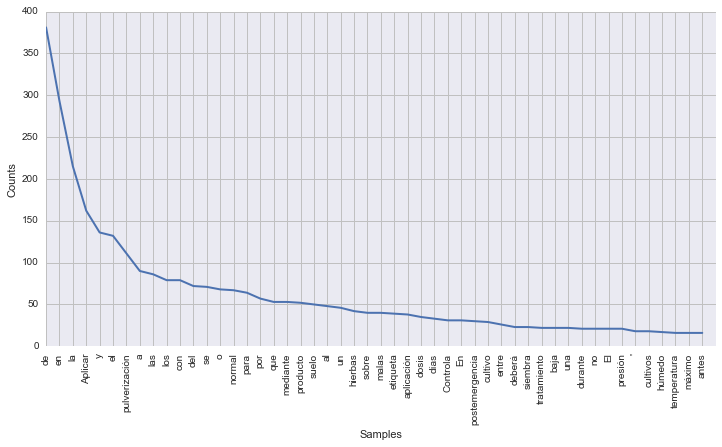

In [34]:
from nltk.tokenize import word_tokenize
stopwords = ["(",")",",","."]

per = permissions.as_matrix(["rule"])

permission_tokens = [token for sentence in per
             for token in word_tokenize(sentence[0]) if token not in stopwords]

plt.figure(figsize=(12,6))
fdist = nltk.FreqDist(permission_tokens)
fdist.plot(50)

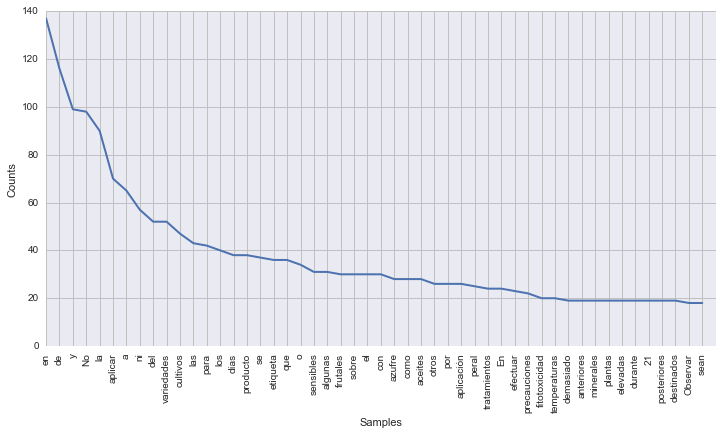

In [11]:
pro = prohibitions.as_matrix(["rule"])
prohibition_tokens = [token for sentence in pro
             for token in word_tokenize(sentence[0]) if token not in stopwords]
plt.figure(figsize=(12,6))
fdist = nltk.FreqDist(prohibition_tokens)
fdist.plot(50)

## Lexical diversity

In [12]:
rules = permission_tokens + prohibition_tokens

print("All", len(set(rules)))
print("Prohibition", len(set(prohibition_tokens)))
print("Permission", len(set(permission_tokens)))

All 1190
Prohibition 390
Permission 1034


## Overlapping vocabularies

In [9]:
count = 0
for prohibition_token in set(prohibition_tokens):
    if prohibition_token in permission_tokens:
        count += 1
        
print("permission", count/len(set(permission_tokens)))
print("prohibition", count/len(set(prohibition_tokens)))

permission 0.2263056092843327
prohibition 0.6


In [ ]:
extractor = TfidfVectorizer(use_idf=True, stop_words=stop_words)

costs = np.arange(2,50,5)
axis_costs = np.arange(1,50,5)
extractor.fit(X)
print()

In [4]:
models = [#("Grammar", ProhibitionGrammarClassifier),
          #("Decision Tree", DecisionTreeClassifier), 
          ("Random Forest", RandomForestClassifier),
          ("Naive Bayes", MultinomialNB),
          ("Linear SVC", SVC),
          ("Always Positive", DummyClassifier),
          ]

def init():
    recall_avg = {}
    recall_std = {}
    precision_avg = {}
    precision_std = {}
    
    for model in models:
        recall_avg[model[0]] = []
        recall_std[model[0]] = []
        precision_avg[model[0]] = []
        precision_std[model[0]] = []
        
    return recall_avg, recall_std, precision_avg, precision_std

In [18]:
# like the ShuffleSplit strategy, stratified random splits do not guarantee 
#that all folds will be different, although this is still very likely for sizeable datasets
sss = StratifiedShuffleSplit(y, n_iter = 10, test_size=0.2, random_state=0)

recall_avg, recall_std, precision_avg, precision_std = init()

for estimator in models:
    for cost in costs:
        if estimator[0] == "Naive Bayes":
            model = estimator[1](class_prior=[1/cost, (cost-1)/cost], fit_prior= False)
        elif estimator[0] == "Random Forest":
            model = estimator[1](class_weight={1:cost-1}, n_estimators = 20)
        elif estimator[0] == "Linear SVC":
            model = estimator[1](class_weight={1:cost-1}, kernel = "linear")
        elif estimator[0] == "Always Positive":
            model = estimator[1](strategy = "constant", random_state = 2016, constant=1)
        elif estimator[0] == "Grammar":
            model = estimator[1]()
        else:
            model = estimator[1](class_weight={1:cost-1})
        precisions = []
        recalls = []
        for train_index, test_index in sss:
            if estimator[0] != "Grammar":
                X_train, X_test = extractor.transform(X)[train_index], extractor.transform(X)[test_index]
                y_train, y_test = y[train_index], y[test_index]
                model.fit(X_train, y_train)
                precisions.append(precision_score(y_test, model.predict(X_test), pos_label=1))
                recalls.append(recall_score(y_test, model.predict(X_test), pos_label=1))
            else:
                X_train, X_test = np.array(X)[train_index], np.array(X)[test_index]
                y_train, y_test = y[train_index], y[test_index]
                model.fit(X_train, y_train)
                precisions.append(precision_score(y_test, model.predict(X_test), pos_label=1))
                recalls.append(recall_score(y_test, model.predict(X_test), pos_label=1))
        recall_avg[estimator[0]].append(np.average(recalls))
        recall_std[estimator[0]].append(np.std(recalls))
        precision_avg[estimator[0]].append(np.average(precisions))
        precision_std[estimator[0]].append(np.std(precisions))

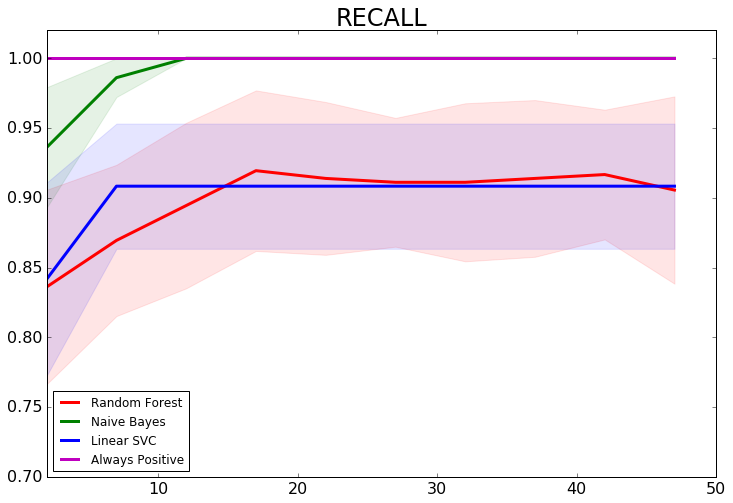

In [19]:
colors = "rgbmyc"
plt.figure(figsize=(12,8))
plt.ylim([0.7, 1.02])
plt.xlim([2, 50])
plt.title("RECALL")
for model, color in zip(models, colors):
    plt.plot(costs, recall_avg[model[0]], color=color, label=model[0])
    plt.fill_between(costs, np.asarray(recall_avg[model[0]]) - recall_std[model[0]], 
                 np.asarray(recall_avg[model[0]]) + recall_std[model[0]], 
                 alpha=0.1, color=color)
    
plt.style.use('paper.mplstyle')
plt.legend(loc='better')

save_image(plt,'../images/', 'recall')
plt.show()

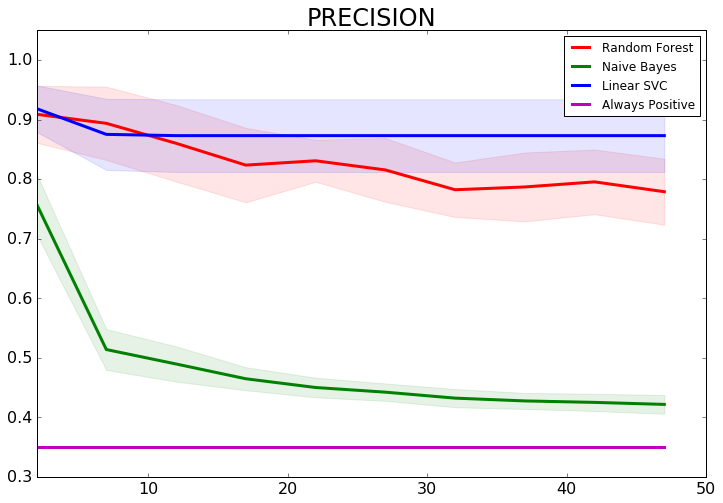

In [20]:
colors = "rgbmyc"
plt.figure(figsize=(12,8))
plt.ylim([0.3, 1.05])
plt.xlim([2, 50])
plt.title("PRECISION")
for model, color in zip(models, colors):
    plt.plot(costs, precision_avg[model[0]], color=color, label=model[0])
    plt.fill_between(costs, np.asarray(precision_avg[model[0]]) - precision_std[model[0]], 
                 np.asarray(precision_avg[model[0]]) + precision_std[model[0]], 
                 alpha=0.1, color=color)
 
plt.style.use('paper.mplstyle')
plt.legend(loc='better')

save_image(plt,'../images/', 'precision')
plt.show()

## Changing weights (Best results from the above experiments)

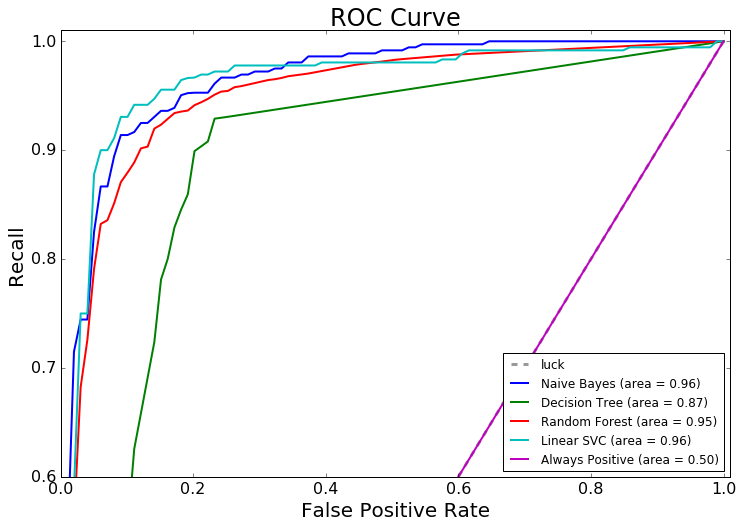

In [22]:
# Classification and ROC analysis
sss = StratifiedShuffleSplit(y, n_iter = 10, test_size=0.2, random_state=0)

X, y = fito_dataset["data"], fito_dataset["target"]
X_trans = extractor.transform(X)

models = [("Naive Bayes", MultinomialNB()),
          ("Decision Tree", DecisionTreeClassifier(class_weight={1:100})),
          ("Random Forest", RandomForestClassifier(class_weight={1:1000})),
          ("Linear SVC", SVC(kernel = "linear", class_weight={1:100}, probability=True)),
          ("Always Positive", DummyClassifier(strategy='constant', constant=1))]


plt.figure(figsize=(12,8))
plt.plot([0,1], [0,1], '--', color=(0.6,0.6,0.6), label='luck')

for model in models:
    mean_tpr = 0.0
    mean_fpr = np.linspace(0,1,100)
    for i, (train, test) in enumerate(sss):
        probas_ = model[1].fit(X_trans[train], y[train]).predict_proba(X_trans[test])
        fpr, tpr, thresholds = roc_curve(y[test], probas_[:, 1], pos_label=1)
        mean_tpr += interp(mean_fpr, fpr, tpr)
        roc_auc = auc(fpr, tpr)
        #plt.plot(fpr, tpr, lw =1, label = 'ROC fold %d (area = %0.2f)' % (i, roc_auc))
    mean_tpr /= len(sss)
    mean_tpr[-1] = 1.0
    mean_auc = auc(mean_fpr, mean_tpr)
    plt.plot(mean_fpr, mean_tpr, label='%s (area = %0.2f)' % (model[0], mean_auc), lw = 2)
        
plt.ylim([0.6, 1.01])
plt.xlim([0.0, 1.01])
plt.xlabel('False Positive Rate')
plt.ylabel('Recall')
plt.title('ROC Curve')
plt.legend(loc="lower right")
save_image(plt,'../images/', 'roc_curves')
plt.show()

## Weighting schema selection

In [76]:
extractors = [("TF", TfidfVectorizer(use_idf=False, stop_words=stop_words)),
              ("TF-IDF", TfidfVectorizer(use_idf=True, stop_words=stop_words))]

#models = [("nb", MultinomialNB)]

def init_ws():
    recall_avg = {}
    recall_std = {}
    precision_avg = {}
    precision_std = {}
    
    for extractor in extractors:
        recall_avg[extractor[0]] = []
        recall_std[extractor[0]] = []
        precision_avg[extractor[0]] = []
        precision_std[extractor[0]] = []
        
    return recall_avg, recall_std, precision_avg, precision_std

In [78]:
recall_avg, recall_std, precision_avg, precision_std = init_ws()

for estimator in models:
    for extractor in extractors:
        extractor[1].fit(X)
        for cost in costs:
            model = estimator[1](class_prior=[1/cost, (cost-1)/cost])
            precisions = []
            recalls = []
            for train_index, test_index in sss:
                X_train, X_test = extractor[1].transform(X)[train_index], extractor[1].transform(X)[test_index]
                y_train, y_test = y[train_index], y[test_index]
                model.fit(X_train, y_train)
                precisions.append(precision_score(y_test, model.predict(X_test), pos_label=1))
                recalls.append(recall_score(y_test, model.predict(X_test), pos_label=1))
            recall_avg[extractor[0]].append(np.average(recalls))
            recall_std[extractor[0]].append(np.std(recalls))
            precision_avg[extractor[0]].append(np.average(precisions))
            precision_std[extractor[0]].append(np.std(precisions))

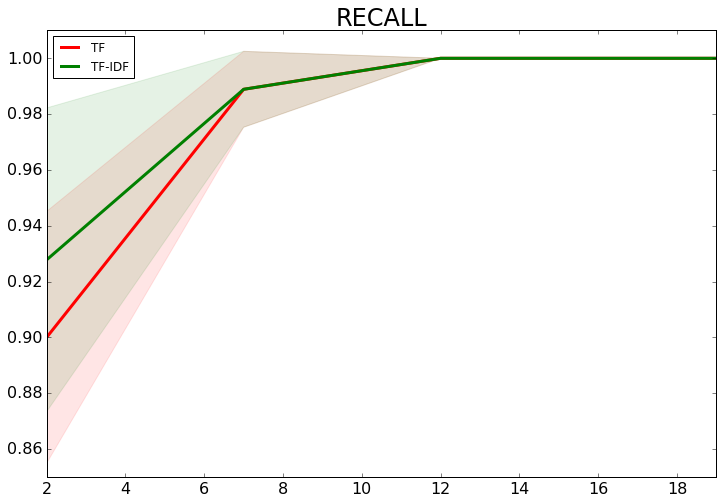

In [79]:
colors = "rgbmy"
plt.figure(figsize=(12,8))
plt.xlim([2, 19])
plt.title("RECALL")
names = ["TF", "TF-IDF"]

for model, color in zip(names, colors):
    plt.plot(costs, recall_avg[model], color=color, label=model)
    plt.fill_between(costs, np.asarray(recall_avg[model]) - recall_std[model], 
                 np.asarray(recall_avg[model]) + recall_std[model], 
                 alpha=0.1, color=color)

plt.ylim([0.85, 1.01])
plt.legend(loc='better')
save_image(plt,'../images/', 'recall_ws')
plt.show()

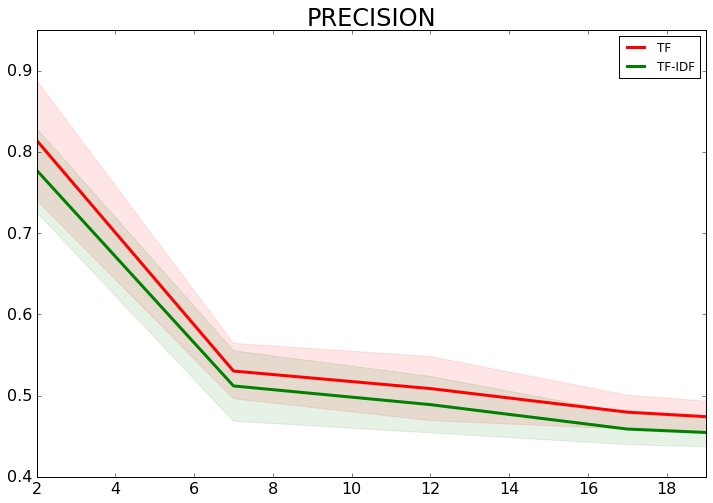

In [80]:
colors = "rgbmy"
plt.figure(figsize=(12,8))
plt.xlim([2, 19])
plt.title("PRECISION")
names = ["TF", "TF-IDF"]

for model, color in zip(names, colors):
    plt.plot(costs, precision_avg[model], color=color, label=model)
    plt.fill_between(costs, np.asarray(precision_avg[model]) - precision_std[model], 
                 np.asarray(precision_avg[model]) + precision_std[model], 
                 alpha=0.1, color=color)

plt.ylim([0.4, 0.95])    
plt.legend(loc='better')
save_image(plt,'../images/', 'precision_ws')
plt.show()

### Stemming

In [128]:
from nltk.stem import WordNetLemmatizer
from nltk.stem.snowball import SnowballStemmer
from nltk.stem.porter import PorterStemmer

In [129]:
class LemmaTokenizer(object):
    def __init__(self):
        self.wnl = SnowballStemmer(language="spanish")
    
    def __call__(self, doc):
        return [self.wnl.stem(t) for t in word_tokenize(doc)]

In [130]:
extractors = [("Not Stemming", TfidfVectorizer(tokenizer=None, use_idf=True, stop_words=stop_words)),
              ("Stemming", TfidfVectorizer(tokenizer=LemmaTokenizer(), use_idf=True, stop_words=stop_words))]

models = [("Naive Bayes", MultinomialNB)]

costs = np.arange(2,30,5)
axis_costs = range(1,29)
print()

In [132]:
def init(extractors, models):
    recall_avg = {}
    recall_std = {}
    precision_avg = {}
    precision_std = {}
    names = []
    vocabulary_sizes = {}
    for model in models:
        for extractor in extractors:
            name = extractor[0]
            recall_avg[name] = []
            recall_std[name] = []
            precision_avg[name] = []
            precision_std[name] = []
            names.append(name)
            vocabulary_sizes[extractor[0]] = []
        
    return names, recall_avg, recall_std, precision_avg, precision_std, vocabulary_sizes

In [140]:
sss = StratifiedShuffleSplit(y, n_iter = 5, test_size=0.2, random_state=0)
names, recall_avg, recall_std, precision_avg, \
    precision_std, vocabulary_sizes = init(extractors, models)

for i, extractor in enumerate(extractors):
    extractor[1].fit(X)
    print(extractor[0] + " " + str(len(extractor[1].vocabulary_)))
    for cost in costs:
        model = MultinomialNB(class_prior=[1/cost, (cost-1)/cost], fit_prior= False)
        precisions = []
        recalls = []
        for train_index, test_index in sss:
            X_train, X_test = extractor[1].transform(X)[train_index], extractor[1].transform(X)[test_index]
            y_train, y_test = y[train_index], y[test_index]
            model.fit(X_train, y_train)
            precisions.append(precision_score(y_test, model.predict(X_test), pos_label=1))
            recalls.append(recall_score(y_test, model.predict(X_test), pos_label=1))
        recall_avg[extractor[0]].append(np.average(recalls))
        recall_std[extractor[0]].append(np.std(recalls))
        precision_avg[extractor[0]].append(np.average(precisions))
        precision_std[extractor[0]].append(np.std(precisions))

Not Stemming 1071
Stemming 880


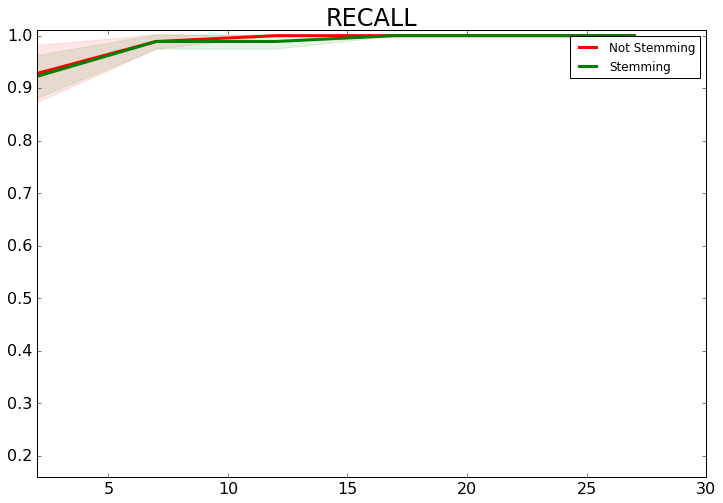

In [141]:
colors = "rg"

plt.figure(figsize=(12,8))
plt.xlim([2, 30])
plt.title("RECALL")
for name, color in zip(names, colors):
    plt.plot(costs, recall_avg[name], color=color, label=name)
    plt.fill_between(costs, np.asarray(recall_avg[name]) - recall_std[name], 
                 np.asarray(recall_avg[name]) + recall_std[name], 
                 alpha=0.1, color=color)

plt.ylim([0.16, 1.01])
plt.legend(loc='better')
save_image(plt,'../images/', 'recall_stemming')
plt.show()

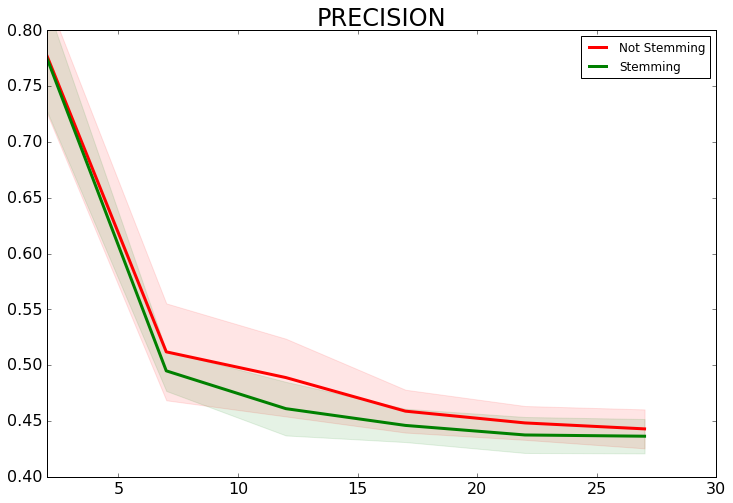

In [136]:
colors = "rg"

plt.figure(figsize=(12,8))
plt.xlim([2, 30])
plt.title("PRECISION")
for name, color in zip(names, colors):
    plt.plot(costs, precision_avg[name], color=color, label=name)
    plt.fill_between(costs, np.asarray(precision_avg[name]) - precision_std[name], 
                 np.asarray(precision_avg[name]) + precision_std[name], 
                 alpha=0.1, color=color)

plt.ylim([0.4, 0.8])
plt.legend(loc='better')
save_image(plt,'../images/', 'precision_stemming')
plt.show()

### N-grams will increase recall?

In [123]:
from sklearn.feature_extraction.text import CountVectorizer
stop_words = ['a', 'bajo', 'en', 'para','un', 'la', 'el', 'los', 'las', 'su', 'sus', 'través', 'al','con', \
             'más', 'muy', 'cual', 'poco', 'que']

extractors = [("unigrams", TfidfVectorizer(use_idf=True, stop_words=stop_words)),
              ("n-grams(1..2)", TfidfVectorizer(ngram_range=(1, 2), use_idf=True, stop_words=stop_words)),
             ("n-grams(2..2)", TfidfVectorizer(ngram_range=(2, 2), use_idf=True, stop_words=stop_words)),
             ]

models = [("Naive Bayes", MultinomialNB)]

costs = np.arange(2,30,5)
axis_costs = range(1,29)
print()

In [124]:
# like the ShuffleSplit strategy, stratified random splits do not guarantee 
#that all folds will be different, although this is still very likely for sizeable datasets
sss = StratifiedShuffleSplit(y, n_iter = 5, test_size=0.2, random_state=0)
names, recall_avg, recall_std, precision_avg, \
    precision_std, vocabulary_sizes = init(extractors, models)

for i, extractor in enumerate(extractors):
    extractor[1].fit(X)
    print(extractor[0] + " " + str(len(extractor[1].vocabulary_)))
    vocabulary_sizes[extractor[0]] = len(extractor[1].vocabulary_)
    for cost in costs:
        model = MultinomialNB(class_prior=[1/cost, (cost-1)/cost], fit_prior= False)
        precisions = []
        recalls = []
        for train_index, test_index in sss:
            X_train, X_test = extractor[1].transform(X)[train_index], extractor[1].transform(X)[test_index]
            y_train, y_test = y[train_index], y[test_index]
            model.fit(X_train, y_train)
            precisions.append(precision_score(y_test, model.predict(X_test), pos_label=1))
            recalls.append(recall_score(y_test, model.predict(X_test), pos_label=1))
        recall_avg[extractor[0]].append(np.average(recalls))
        recall_std[extractor[0]].append(np.std(recalls))
        precision_avg[extractor[0]].append(np.average(precisions))
        precision_std[extractor[0]].append(np.std(precisions))

words 1071
n-grams(1..2) 3327
n-grams(2..2) 2256


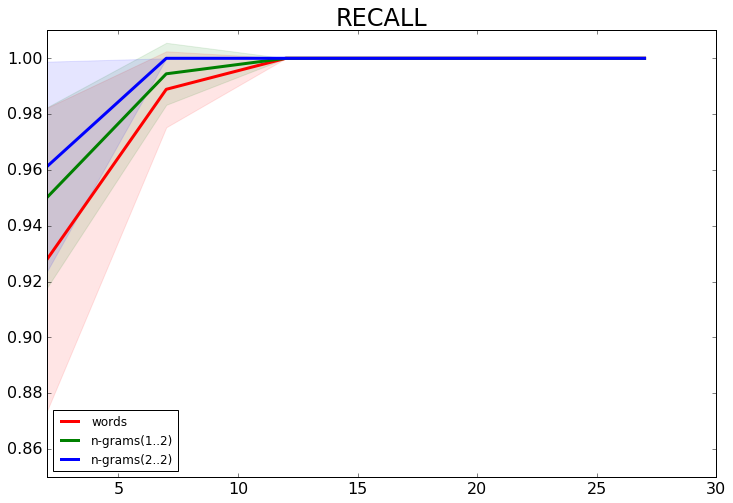

In [125]:
colors = "rgbmyck"

plt.figure(figsize=(12,8))
plt.xlim([2, 30])
plt.title("RECALL")
for name, color in zip(names, colors):
    plt.plot(costs, recall_avg[name], color=color, label=name)
    plt.fill_between(costs, np.asarray(recall_avg[name]) - recall_std[name], 
                 np.asarray(recall_avg[name]) + recall_std[name], 
                 alpha=0.1, color=color)

plt.ylim([0.85, 1.01])
plt.legend(loc='better')
save_image(plt,'../images/', 'recall_n-gram')
plt.show()
plt.show()

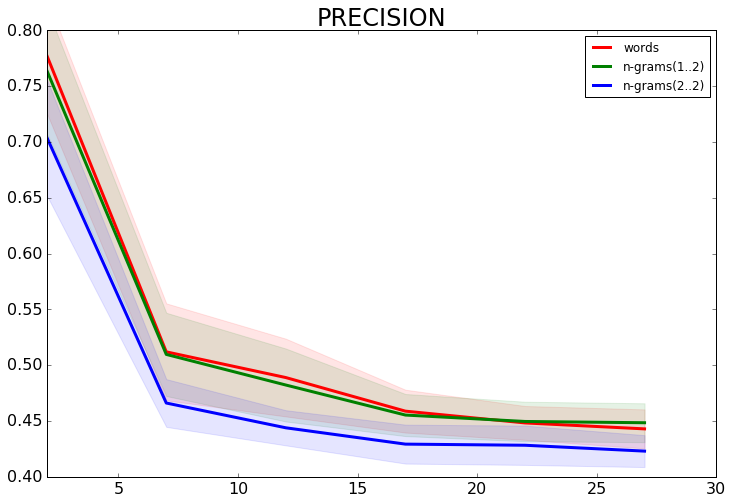

In [126]:
colors = "rgbmyck"

plt.figure(figsize=(12,8))
plt.ylim([0.4, 0.8])
plt.xlim([2, 30])
plt.title("PRECISION")
for name, color in zip(names, colors):
    plt.plot(costs, precision_avg[name], color=color, label=name)
    plt.fill_between(costs, np.asarray(precision_avg[name]) - precision_std[name], 
                 np.asarray(precision_avg[name]) + precision_std[name], 
                 alpha=0.1, color=color)

plt.legend(loc='better')
save_image(plt,'../images/', 'precision_n-gram')
plt.show()